In [ ]:
from Interface.Utils import *
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import rasterio


In [10]:
# point cloud is in .npy format [x,y,z,obj_label]
point_cloud_folder = r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out'
pc_folders = os.listdir(point_cloud_folder)
for folder in pc_folders:
    frame_names = os.listdir(os.path.join(point_cloud_folder, folder))
    total_point_clouds = []
    for frame in frame_names:
        point_cloud = np.load(os.path.join(point_cloud_folder, folder, frame))
        total_point_clouds.append(point_cloud)
    break

In [12]:
total_point_clouds_frame = np.concatenate(total_point_clouds, axis=0)

In [ ]:
# convert to density map and conver to raster file using rasterio


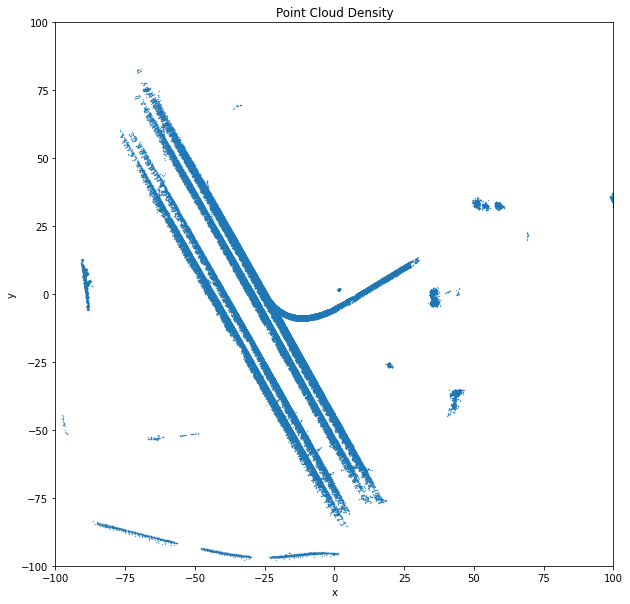

In [17]:
# plot density of point cloud in 2D
plt.figure(figsize=(10, 10))
plt.scatter(total_point_clouds_frame[:, 0], total_point_clouds_frame[:, 1], s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Point Cloud Density')
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

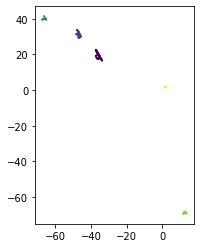

In [9]:
# plot 2d point cloud with object labels
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=1,c=point_cloud[:, 3])
plt.show()


In [3]:
sys.path

['d:\\CodeRepos\\Lidar-Tracker\\LiDAR_Tracker_Project_v3.1',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\python38.zip',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\DLLs',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3',
 '',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages\\win32',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages\\Pythonwin',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages\\IPython\\extensions',
 'c:\\Users\\zhChe\\anaconda3\\envs\\tracking3\\lib\\site-packages\\setuptools\\_vendor',
 'C:\\Users\\zhChe\\.ipython']